# Importación de los datos

En primer lugar se importarán los ficheros relativos al conjunto de datos de **entrenamiento** y **test**. Para ello se han descargado de la competición de Kaggle y se han subido a un repositorio público en **GitHub** desde donde se importarán. Haciendo esto evitamos tener que adjuntar al notebook los ficheros cada vez que vayamos a trabajar, ya que estos se **importarán automáticamente** desde el repositorio.

In [1]:
import pandas as pd
import requests
import io

train_url = "https://raw.githubusercontent.com/cturienzo/LinearRegressionDataset/main/train.csv"
test_url = "https://raw.githubusercontent.com/cturienzo/LinearRegressionDataset/main/test.csv"

train_request = requests.get(train_url).content
test_request = requests.get(test_url).content

train = pd.read_csv(io.StringIO(train_request.decode('utf-8')))
test = pd.read_csv(io.StringIO(test_request.decode('utf-8')))


Una vez importados los datos, vamos a separarlos en diferentes variables para facilitar la comprensión:

**X_train** se corresponderá con la matriz que contiene los valores de las características del conjunto de datos de entrenamiento.

**y_train** se corresponderá con la matriz unidimensional de valores de la variable objetivo.

**X_test** se corresponderá con la matriz que contiene los valores de las características del conjunto de datos de test.

In [6]:
X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]
X_test = test

# Pre-procesamiento

### Variables Continuas

Para estudiar las variables continuas observamos su relación con la variable objetivo así como su distribución. De esta forma podremos aplicar un transformador u otro.

**Nota**: la variable edad a pesar de ser discreta, toma mucho valores diferentes y se tratará como una variable aleatoria continua.

In [75]:
import matplotlib.pyplot as plt

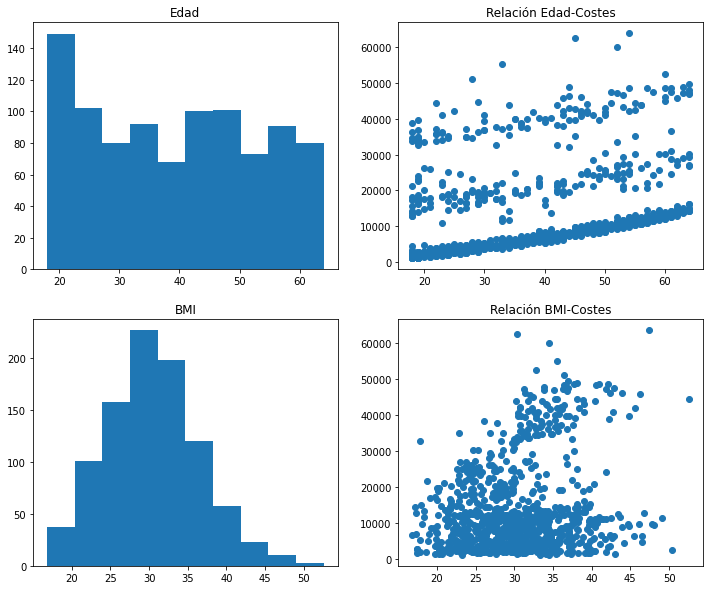

In [74]:
from sklearn.preprocessing import StandardScaler


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

axs[0, 0].set_title('Edad')
axs[0, 0].hist(train["age"])

axs[0, 1].set_title('Relación Edad-Costes')
axs[0, 1].scatter(train["age"], y_train)

axs[1, 0].set_title('BMI')
axs[1, 0].hist(train["bmi"])

axs[1, 1].set_title('Relación BMI-Costes')
axs[1, 1].scatter(train["bmi"], y_train)






### Variables Discretas

Para estudiar las variables discretas vamos a conocer la relación de cada una con su variable objetivo.

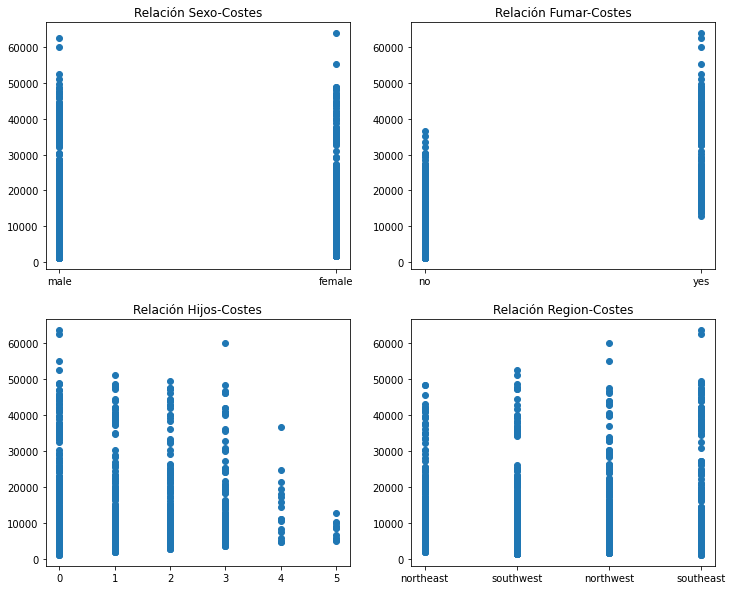

In [73]:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

axs[0, 0].set_title('Relación Sexo-Costes')
axs[0, 0].scatter(train["sex"], y_train)

axs[0, 1].set_title('Relación Fumar-Costes')
axs[0, 1].scatter(train["smoker"], y_train)

axs[1, 0].set_title('Relación Hijos-Costes')
axs[1, 0].scatter(train["children"], y_train)

axs[1, 1].set_title('Relación Region-Costes')
axs[1, 1].scatter(train["region"], y_train)

Tras el análisis y el estudio de las diferentes features, aplicaremos a cada una los siguientes **transformadores**:
1. **Id**: *Drop*. Lo vamos eliminar del conjunto de datos pues no influye en la variable objetivo.
2. **Age**: *Passthrough*. 
3. **Sex**: *OneHotEncoder* 
4. **BMI**: *Passthrough*.
5. **Children**: *OneHotEnconder*
6. **Smoker**: *OneHotEncoder* 
7. **Region**: usaremos *OrdinalEnconder*.

In [26]:
import sklearn.compose
column_transformer = sklearn.compose.ColumnTransformer(transformers=[
    ("id drop", "drop", [0]),
    ("age","passthrough", [1]), 
    ("sex", sklearn.preprocessing.OneHotEncoder(), [2]),
    ("bmi", "passthrough", [3]),
    ("children",sklearn.preprocessing.OneHotEncoder(), [4]),  
    ("smoker", sklearn.preprocessing.OneHotEncoder(), [5]),
    ("region", sklearn.preprocessing.OrdinalEncoder(), [6]),
   
])

X_train_transform = column_transformer.fit_transform(X_train)
X_test_transform = column_transformer.fit_transform(X_test)
X_train_transform

# Entrenamiento del modelo

Para el entrenamiento del modelo, hemos decidido utilizar [***XGBRegressor***](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) (*Extreme Gradient Boosting*)

In [25]:
from xgboost.sklearn import XGBRegressor
xgbr = XGBRegressor(subsample=0.8,                                          
                    n_estimators=500,                                           
                    max_depth=3,                                          
                    learning_rate= 0.01,                                          
                    colsample_bytree = 1,                                          
                    colsample_bylevel= 1,                     
                    random_state= 43                             
                    ).fit(X_train_transform, y_train)
y_pred = xgbr.predict(X_test_transform)
y_pred

**learning_rate** este parámetro es la velocidad de aprendizaje del modelo. Valores muy elevados aprenderá demasiado rápido y no se ajustrá correctamente. Sin embargo valores muy pequeños tendrán el riesgo de ajustarse mucho y caer en mínimos locales. Hay que buscar el valor adecuado para el aprendizaje del modelo.

**num_estimators** este parámetro son el número de árboles que se crean para el aprendizaje del modelo.

**max_depth** este parámetro trata la profundidad de los árboles.

**subsample** este parámetro nos indica el ratio de las submuestras con las instancias de formación.

**random_state** este parámetro define la semilla de aleatoriedad que utiliza el modelo para su entrenamiento. De esta forma siempre utilizará la misma semilla y no producirá resultados distintos en cada entrenamiento.

**colsample_bytree** este parámetro nos indica la proporción de columnas de la submuestra al construir cada árbol.

**colsample_bylevel** este parámetro nos indica la proporción de columnas de la submuestra para cada nivel del árbol.


Para evitar el *overfitting* en nuestro modelo hemos utilizado el parametro **subsample** que ayuda a que el modelo sea más conservativo, por lo tanto, que se reduzca el *overfitting*. También para evitar el *overfitting* hemos ajustado los parametros **max_depth** y **learning_rate**, valores altos de estos parametro provocan que el modelo sea mas complejo y mas apto para el *overfitting*. Por otro lado, el **num_estimators** también influye en el *overfitting*, si aumentamos el num_árboles

# Validación del modelo

Para la validación del modelo se realizará **validación cruzada** realizando  **10**  separaciones diferentes y aleatorias del conjunto de datos para calcular las medidas de calidad de cada una de estas separaciones y luego agruparlas con la **media**.

In [78]:


from sklearn.model_selection import cross_val_score
import numpy as np

scores = cross_val_score(xgbr, X_train_transform, y_train, cv=10, scoring='r2')
np.mean(scores), xgbr.score(X_train_transform, y_train)

(0.8489082510415058, 0.8844295606181548)

### Generación csv predicciones

Una vez entrenado y validado el modelo, se **generará el csv** con las predicciones y se subirá a la competición.

In [0]:
predicciones = pd.DataFrame({'id':X_test["id"], 'charges': y_pred })
predicciones.to_csv("prediccionesXGB.csv", index=False)

<hr>

Creado por **Pablo Gutiérrez Rojas** (p.grojas@alumnos.upm.es) y **César Turienzo Forcada** (c.turienzo@alumnos.upm.es)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">